# Perceptual Losses in PyTorch

## Introduction

In this notebook, I will be implementing Johnson et. al's (2016) [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) paper. Specifically, I will be focusing with the style transfer aspect from this paper. In order to understand the implementation of this paper, it is ideal to go through the key concepts laid out by Johnson et. al.

### Architecture

In **Figure 1**, taken from the paper, is the overall architecture defined by Johnson et. al's paper.

# ![](data/img/architecture.png)
**Figure 1:** The image transformation network (ITN) and the loss network (LN) are key networks required to produce quality style transferred images.

As show in **Figure 1**, there are two networks required to make style transfer happen at a faster speed than the one proposed by Gatys et. al's [paper](https://arxiv.org/abs/1508.06576): **image transformation network** and **loss network**. Let's define each of these networks and their key contributions to the overall architecture.

### Image Transformation Network

An image transformation network is a network which learns to reproduce an image for a given task. This network has three key characteristics in order to reproduce an image: downsampling, upsampling, and residual blocks. Downsampling learns the semantic features of an image. Upsampling learns to reproduce the image through consecutive deconvolutional layers. Residual blocks help to carry information from the downsampling path to the upsampling path through concatenation. As far as model architecture is concerned, image segmentation based models, such as [U-Net](https://arxiv.org/abs/1505.04597), are a perfect candidate to become an image transformation network.

### Loss Network

A loss network is used as a feature extractor for pre-defined layers of a pre-trained network. In Johnson et. al's paper, they have used the **VGG-16** model architecture pre-trained on ImageNet dataset. The motivation for this is that when $\hat{y}$, $y_c$, and $y_s$ are put through this network, the pre-defined layer outputs give insight about how to construct an image given its content or its style. Note that a loss network is only used for evaluation purposes and is _not_ trained like the image transformation network.

### Putting it all together for style transfer

Given the definitions of image transformation and loss networks, we can describe how to put it all together for the style-transfer task.

First, we only update the parameters of the image transformation network while the loss network's parameters are not. In addition, pre-define the layers to use from the loss network. In this case, VGG-16's `relu1_2`, `relu2_2`, `relu3_3`, and `relu4_3` are used.

For an input image, $x$, we create an output image, $\hat{y}$, by running it through the image transformation network. Next, set style target, $y_s$, to an image from which we want the style features to come from. Also, set content target, $y_c$, to be $x$. Then, take $\hat{y}$, $y_c$, and $y_s$  and run it through the loss network. Finally, take the pre-defined layer outputs and calculate the loss function as defined in **figure 2**.

![](data/img/style_transfer_loss_function.png)
**Figure 2:** The style transfer loss function.

## Implementation

In this notebook, I will be using the PyTorch framework to implement this paper for the style transfer task.

### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from tqdm import tqdm_notebook
from models.transformer_net import TransformerNet
from pathlib import Path

### Constants

In [2]:
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Filepaths
DATASET_PATH = "data/dataset/coco/"
STYLE_TARGET_PATH = "data/img/style_target.jpg"
TEST_IMAGE_PATH = "data/img/test_image.jpg"
MODEL_CHECKPOINT_FILEPATH = "models/checkpoints/{}.pth"
STYLED_IMAGE_FILEPATH = "data/img/{}.jpg"

# Image sizes
TRAINING_IMAGE_SIZE = (256, 256)
INPUT_IMAGE_SIZE = (512, 512)

# VGG-16 normalization values
VGG_16_MEAN = [0.485, 0.456, 0.406]
VGG_16_STD_DEV = [0.229, 0.224, 0.225] 

# VGG-16 layer indices
LAYER_INDICES = [3, 8, 15, 22]
FEATURE_LAYER_INDEX = 1

# Perceptual loss hyperparameters
ALPHA = 1e0
BETA = 1e4

# Model checkpoint keys
MODEL_KEY = "model"
OPTIMIZER_KEY = "optimizer"
EPOCH_KEY = "epoch"

# Training hyperparameters
BATCH_SIZE = 4
LR = 1e-3
N_EPOCHS = 2

### Helpers

Here are some helper functions that I will be using for the rest of this project.

In [3]:
# Image utilities
def show_image(image):
    """Returns the image in with all channels unnormalized using ImageNet statistics"""
    image_transform = transforms.ToPILImage()
    image = image.squeeze().cpu()

    for index in range(image.size(0)):
        image[index] = (image[index] * VGG_16_STD_DEV[index]) + VGG_16_MEAN[index]
        
    # Ensure to clamp the range of values of every pixel between 0 to 1
    image.clamp_(0, 1)
    
    # Apply transformation as a PIL image
    image = image_transform(image)
    
    return image

def open_image(filepath):
    """Returns a tensor of the given image that has been normalized using ImageNet statistics"""
    image_transforms = transforms.Compose([
        transforms.Resize(INPUT_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(VGG_16_MEAN, VGG_16_STD_DEV)
    ])
    
    with Image.open(filepath).convert("RGB") as image:
        return image_transforms(image)

# Model checkpointing
def save_model_checkpoint(model, optimizer, epoch, filename):
    """Saves the model and optimizer for model checkpointing"""
    checkpoint = {MODEL_KEY: model.state_dict(), 
                  OPTIMIZER_KEY: optimizer.state_dict(), 
                  EPOCH_KEY: epoch}
    torch.save(checkpoint, MODEL_CHECKPOINT_FILEPATH.format(filename))

def load_model_checkpoint(model, optimizer, filename):
    """Loads the model and optimizer states from a model checkpoint"""
    model_checkpoint = torch.load(MODEL_CHECKPOINT_FILEPATH.format(filename))
    model_state_dict, optimizer_state_dict = (model_checkpoint[MODEL_KEY], 
                                              model_checkpoint[OPTIMIZER_KEY])
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    
# Model evaluation
def style_image(model, image, filename=None):
    """Styles an image given a model and optionally saves it as a file"""
    model.eval()
    
    image = image.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        styled_image = model(image)
        
    styled_image = show_image(styled_image)
    if filename != None:
        styled_image.save(STYLED_IMAGE_FILEPATH.format(filename))
        
    return styled_image

### Dataset

In this project, I will be using the [COCO 2014 training images (83K)](http://cocodataset.org/#download). Note that in order to train the model, you will have to download the dataset and updated `DATASET_PATH` constant pointing to its filepath.

Now we'll be creating a `TrainingDataset` subclass to contain all of our training set images.

In [4]:
class TrainingDataset(Dataset):
    def __init__(self, filepaths):
        self.filepaths = list(Path(filepaths).iterdir())
        self.transforms = transforms.Compose([
            transforms.Resize(TRAINING_IMAGE_SIZE),
            transforms.CenterCrop(TRAINING_IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(VGG_16_MEAN, VGG_16_STD_DEV)
        ])
    
    def __getitem__(self, index):
        with Image.open(self.filepaths[index]).convert("RGB") as image:
            image = self.transforms(image)
            return image
    
    def __len__(self):
        return len(self.filepaths)
    
    def create_dataloader(self, batch_size):
        """Creates a dataloader using this dataset"""
        return DataLoader(self, batch_size)

In [5]:
training_ds = TrainingDataset(DATASET_PATH)
training_dl = training_ds.create_dataloader(BATCH_SIZE)

print("There are {} samples.".format(len(training_ds)))

There are 82783 samples.


### Style target

The defaults style target image that will be used is [The Starry Night by Vincent van Gogh](https://en.wikipedia.org/wiki/The_Starry_Night). Since the model is trained on this style target image, any input image can only be styled using this style.

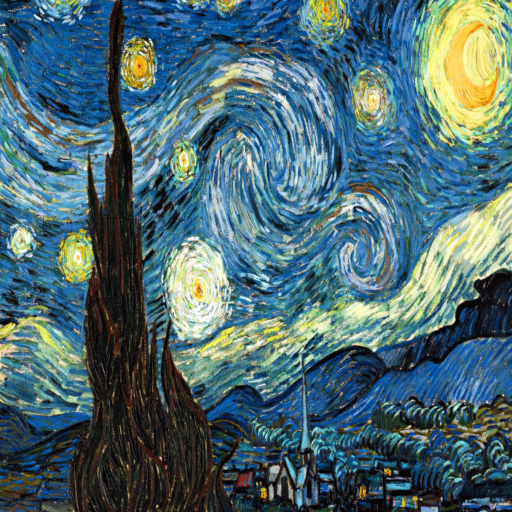

In [6]:
style_target = open_image(STYLE_TARGET_PATH).to(DEVICE)
show_image(style_target)

### Image Transformation network

As for the image transformation network, I will be using `TransformerNet` from the [examples repository](https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/transformer_net.py) by PyTorch.

In [7]:
image_transformation_network = TransformerNet().to(DEVICE)

### Loss network

For the loss network, the pre-trained [VGG-16 model architecture](https://arxiv.org/abs/1409.1556) will be used as suggested by Johnson et. al's (2016) paper. Note that only the `features` are only needed for the loss network. The classifier is not useful for this task.

In [8]:
loss_network = models.vgg16(pretrained=True).features.to(DEVICE).eval()

# Turning off gradient calculations for efficiency
for param in loss_network.parameters():
    param.requires_grad = False

#### Setting up forward hooks

The use of forward hooks is a PyTorch-specific implementation. Every `forward()` call to a layer will invoke a forward hook lambda function. This gives access to the current layer along with its inputs and outputs. I have created a class, `ForwardHookManager`, to manage from setting up the hooks all the way to detaching them from our loss network.

In [9]:
class ForwardHookManager:
    """This class manages all the hook ups and removal for each layer of the model."""
    def __init__(self, model, layer_indices):
        self.hooks = [list(model.children())[index].register_forward_hook(self.forward_hook) for index in layer_indices]
        self.clear_outputs()
        
    def __del__(self):
        for hook in self.hooks:
            hook.remove()
        
    def forward_hook(self, module, input, output):
        """A callback function which captures the outputs of the module"""
        self.layer_outputs.append(output)
        
    def clear_outputs(self):
        """Clears all of captured outputs"""
        self.layer_outputs = []

In [10]:
hook_manager = ForwardHookManager(loss_network, LAYER_INDICES)

### Calculate style target through loss network

For a given style target, we can already calculate its intermediate values defined by `LAYER_INDICES` when we run it through the loss network.

In [11]:
# This copies the style image BATCH_SIZE times
style_target = style_target.repeat(BATCH_SIZE, 1, 1, 1)

loss_network(style_target)
y_style = hook_manager.layer_outputs
hook_manager.clear_outputs()

print("y_style intermediate values count is {}.".format(len(y_style)))

y_style intermediate values count is 4.


### Perceptual loss functions

Next, let's define the **perceptual loss** which is composed of the sum of **style reconstruction loss** and **feature reconstruction loss**.

#### Style reconstruction loss

In [12]:
class StyleReconstructionLoss(nn.Module):
    """This subclass calculates the style reconstruction loss between two intermediate values from the loss network."""
    def __init__(self):
        super(StyleReconstructionLoss, self).__init__()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, prediction, target):
        prediction_gram_matrix = self.calculate_gram_matrix(prediction)
        target_gram_matrix = self.calculate_gram_matrix(target)
        
        return self.mse_loss(prediction_gram_matrix, target_gram_matrix)
    
    def calculate_gram_matrix(self, tensor):
        """Returns the gram matrix of a given tensor"""
        n_batch, n_channels, width, height = tensor.size()
        tensor = tensor.view(n_batch, n_channels, -1)
        
        return tensor.bmm(tensor.transpose(1, 2)) / (n_channels * width * height)

#### Feature reconstruction loss

In [13]:
class FeatureReconstructionLoss(nn.Module):
    """This subclass calculates the feature reconstruction loss between two intermediate values from the loss network."""
    def __init__(self):
        super(FeatureReconstructionLoss, self).__init__()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, prediction, target):
        return self.mse_loss(prediction, target)

#### Perceptual loss

In [14]:
class PerceptualLoss(nn.Module):
    """This subclass calculates the perceptual loss."""
    def __init__(self, alpha, beta):
        super(PerceptualLoss, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.style_loss = StyleReconstructionLoss()
        self.feature_loss = FeatureReconstructionLoss()
        
    def forward(self, y_hat, y_style, y_content):
        style_loss = 0.0
        feature_loss = self.alpha * self.feature_loss(y_hat[FEATURE_LAYER_INDEX], y_content[FEATURE_LAYER_INDEX].detach())
        
        for current_y_hat, current_y_style in zip(y_hat, y_style):
            style_loss += self.style_loss(current_y_hat, current_y_style[:len(current_y_hat)].detach())
            
        style_loss *= self.beta
        
        return feature_loss + style_loss

### Optimizers and loss function

As defined in Johnson et. al's (2016) paper, they used a learning rate of **1e-3 with the Adam optimizer**.

In [15]:
loss_function = PerceptualLoss(ALPHA, BETA)
optimizer = optim.Adam(image_transformation_network.parameters(), lr=LR)

### Training transformation model

Finally, here's the helper method for training the image transformation network.

In [16]:
def train_model(image_transformation_network, 
                loss_network, 
                hook_manager, 
                dataloader, 
                y_style, 
                optimizer, 
                loss_function, n_epochs=N_EPOCHS):
    image_transformation_network.train()
    
    for epoch in tqdm_notebook(range(1, n_epochs + 1), desc="[Training] Progress"):
        print("[Training - Epoch {}] Start".format(epoch))
        
        total_loss = []
        for image in tqdm_notebook(dataloader, desc="Progress"):
            optimizer.zero_grad()
            
            # Add batch dimension as per PyTorch model requirements
            image = image.to(DEVICE)
            
            # Get transformation network output based from the input image
            y_hat = image_transformation_network(image)
            
            # Calculate output of loss network using the output from image transformation network
            loss_network(y_hat)
            y_hat = hook_manager.layer_outputs
            hook_manager.clear_outputs()
            
            # Calculate content target through loss network
            loss_network(image)
            y_content = hook_manager.layer_outputs
            hook_manager.clear_outputs()
            
            # Calculate loss
            loss = loss_function(y_hat, y_style[:len(y_hat)], y_content)
            total_loss.append(loss.item())
            
            # Backpropagate and update parameters
            loss.backward()
            optimizer.step()
            
        print("[Training - Epoch {}] Loss is {:.2f}".format(epoch, sum(total_loss) / len(total_loss)))
        print("[Training - Epoch {}] End\n".format(epoch))
        
    del hook_manager

Now we can train our image transformation network.

In [17]:
# train_model(image_transformation_network,
#             loss_network, 
#             hook_manager, 
#             training_dl, 
#             y_style, 
#             optimizer, 
#             loss_function)

[Training - Epoch 1] Start


[Training - Epoch 1] Loss is 752318.20
[Training - Epoch 1] End

[Training - Epoch 2] Start


[Training - Epoch 2] Loss is 646298.25
[Training - Epoch 2] End




To use save a model checkpoint, uncomment this line of code.

In [18]:
# save_model_checkpoint(image_transformation_network, optimizer, 2, "style-transfer-alpha1e5-beta1e10-epoch-2")

### Test with sample image

Let's load the model checkpoint.

In [17]:
load_model_checkpoint(image_transformation_network, optimizer, "style-transfer-alpha1e5-beta1e10-epoch-2")

Here's our test image:

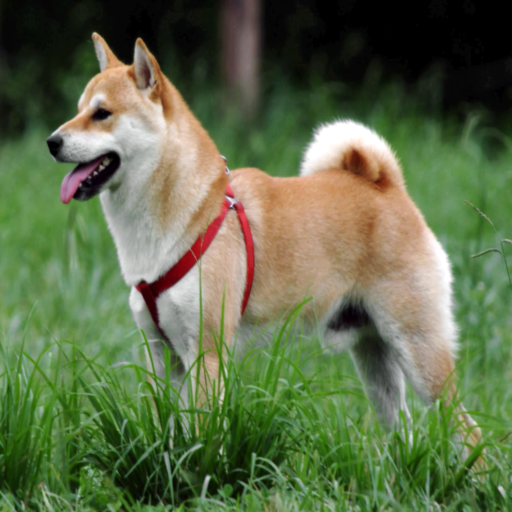

In [18]:
test_image = open_image(TEST_IMAGE_PATH)
show_image(test_image)

Here's how it looks like styled:

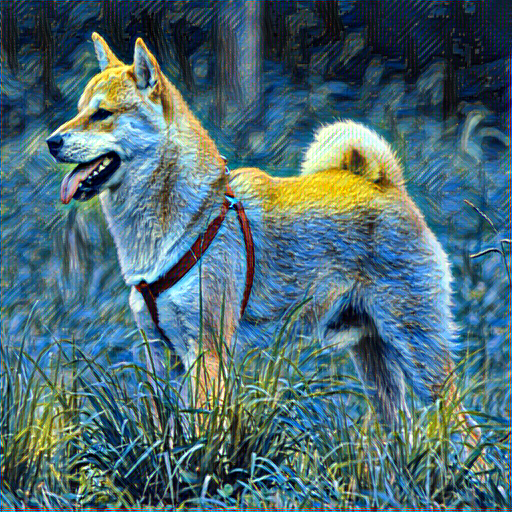

In [19]:
style_image(image_transformation_network, test_image, filename="test_image_styled")